In [1]:
#Distribution
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from shapely.geometry import mapping, shape
from shapely.prepared import prep
from shapely.geometry import Point
import pycountry_convert as pc

# Define a function to get continent name from country name
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return None  # In case the country name is not found or conversion is not possible

# Load your dataframes
df = pd.read_json(r'C:\Users\ogechi\OneDrive - University of Glasgow\bottle\processed_image_data.indoor.json')
df = df.drop('continent', axis=1)

data = gpd.read_file(r'C:\Users\ogechi\OneDrive - University of Glasgow\bottle\countries.geojson')  # Ensure this file contains the necessary columns and geometries.
data['country_bounds'] = data.apply(lambda row: prep(shape(row['geometry'])), axis=1)

countries_gdf = gpd.GeoDataFrame(data, geometry='geometry')

# Convert df to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# Spatial join between points and countries
result = gpd.sjoin(gdf, countries_gdf, how="left", op='within')

# Drop the unnecessary geometry column if no longer needed
result = result.drop(columns=['index_right'])

# Map the 'ADMIN' column from countries to your dataframe
df['ctry'] = result['ADMIN']

df['country_label'] = df['ctry'].combine_first(df['country'])

# Apply the function to create a new column for the continent
df['continent'] = df['country_label'].apply(country_to_continent)

# Optimize the code by grouping the data by country_name and counting the occurrences
country_counts = df.groupby('country_label').size().reset_index(name='counts')
# Group by the new continent column and sum the counts
continent_counts = df.groupby('continent').size().reset_index(name='counts')

C:\Users\ogechi\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\ogechi\anaconda3\envs\pytorch\lib\site-packages\pycountry\db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
C:\Users\ogechi\anaconda3\envs\pytorch\lib\site-packages\pycountry\db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


In [37]:
df['country_label'].nunique()

238

In [48]:
# Group by both 'latitude' and 'longitude' and count the occurrences
location_counts = df.groupby(['latitude', 'longitude']).size().reset_index(name='count')

# Sort the results by 'count' to see the most common locations
sorted_location_counts = location_counts.sort_values(by='count', ascending=False)

# Display the result
print(sorted_location_counts)

         latitude   longitude  count
9273   -30.015003  -51.190795   3852
166423  42.261870  -83.662403   3361
100920  37.445500 -122.167200   1439
183850  43.334527   -3.010296   1319
125520  38.927970  -94.660167   1292
...           ...         ...    ...
118455  38.297706 -122.461639      1
118457  38.298277 -122.284325      1
118460  38.298333 -122.287167      1
118463  38.298851 -122.285186      1
303355  90.000000  180.000000      1

[303356 rows x 3 columns]


In [2]:
#country counts
country_counts.describe()

,counts
count,238.000000
mean,4572.865546
std,28350.359558
min,1.000000
25%,20.000000
50%,118.500000
75%,668.500000
max,415714.000000


In [19]:
#Interested countries
s = 0

sea = dict()

for a in zip(country_counts['country_label'], country_counts['counts']):
    if a[0] in ['Singapore','Malaysia', 'Thailand', 'Indonesia', 'Philippines']:
        print(a)
        s += a[1]
        sea[a[0]] = a[1]
        
s

('Indonesia', 13457)
('Malaysia', 19680)
('Philippines', 15476)
('Singapore', 15177)
('Thailand', 20959)


84749

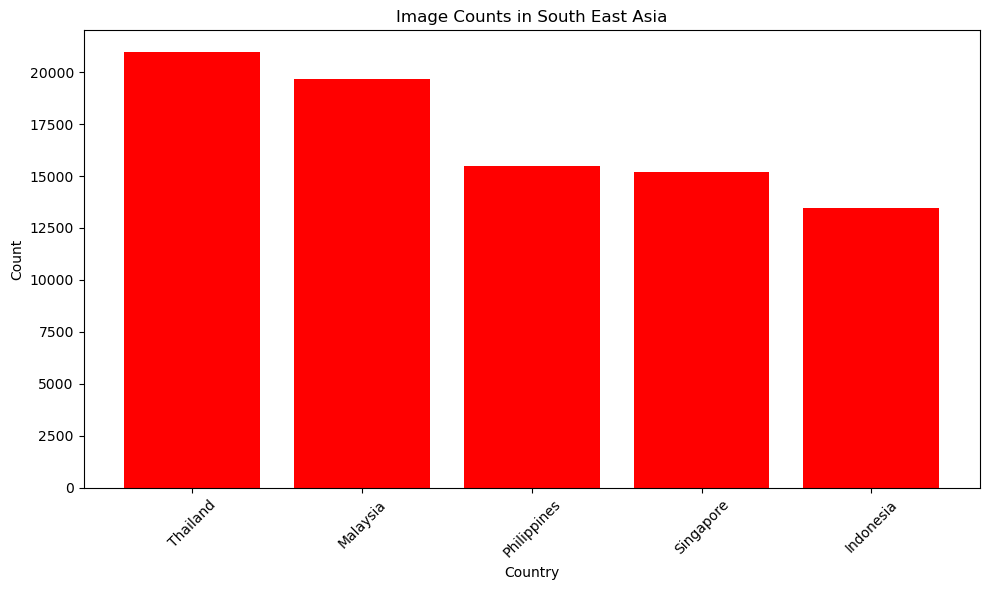

In [18]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sorted_sea = dict(sorted(sea.items(), key=lambda item: item[1],reverse=True))
plt.bar(list(sorted_sea.keys()), list(sorted_sea.values()), color='red')  # Create a bar plot
plt.title('Image Counts in South East Asia')  # Title of the plot
plt.xlabel('Country')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
plt.xticks(rotation=45)  # Rotate the labels on the x-axis for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

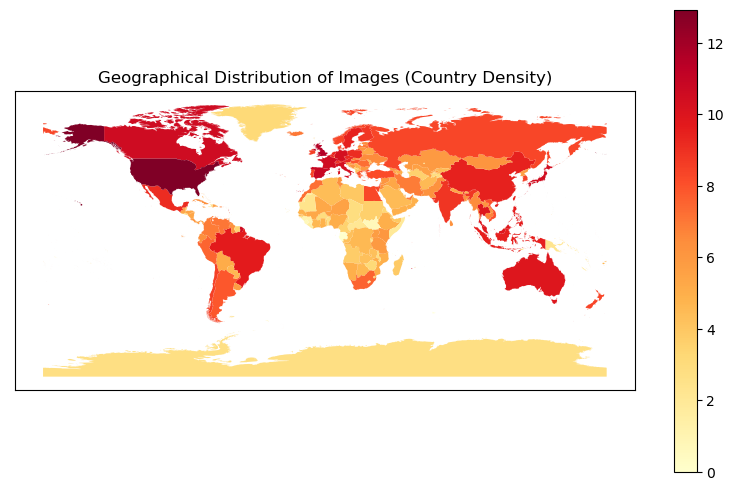

In [5]:
countries_gdf['country_label'] = countries_gdf['ADMIN']
world = countries_gdf.merge(country_counts, on='country_label', how='left').fillna(0)

# Normalize the count values
world['count_norm'] = np.log(world['counts']+1) 

# Plot the choropleth map
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(column='count_norm', ax=ax, cmap='YlOrRd', legend=True)

ax.set_xticks([])
ax.set_yticks([])

# Add a title
ax.set_title('Geographical Distribution of Images (Country Density)')

# Display the map
plt.show()

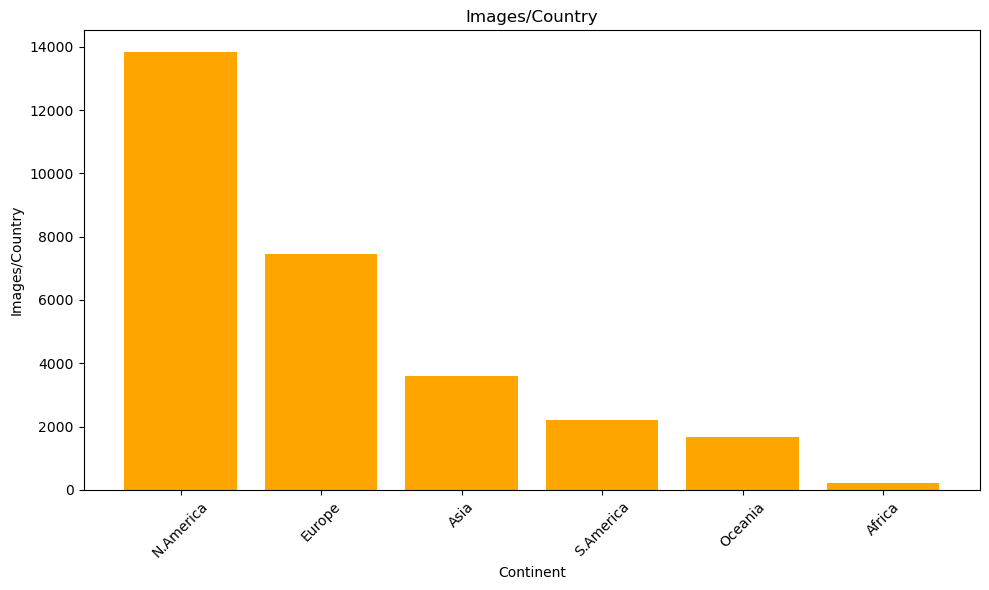

In [46]:
ratios = {'Africa': 11032/51, 'Asia': 183227/51, 'Oceania': 25248/15, 'S.America': 28751/13, 'N.America': 470120/34, 'Europe':365099/49}
ratios = dict(sorted(ratios.items(), key=lambda item: item[1], reverse=True))
#Plotting the data
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.bar(list(ratios.keys()), ratios.values(), color='orange')  # Create a bar plot
plt.title('Images/Country')  # Title of the plot
plt.xlabel('Continent')  # Label for the x-axis
plt.ylabel('Images/Country')  # Label for the y-axis
plt.xticks(rotation=45)  # Rotate the labels on the x-axis for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [47]:
ratios

{'N.America': 13827.058823529413,
 'Europe': 7451.0,
 'Asia': 3592.6862745098038,
 'S.America': 2211.6153846153848,
 'Oceania': 1683.2,
 'Africa': 216.31372549019608}

In [36]:
ctrybyconti = df.groupby('continent')['country_label'].nunique()
ctrybyconti

continent
Africa           51
Asia             51
Europe           49
North America    34
Oceania          15
South America    13
Name: country_label, dtype: int64

       continent  counts
0         Africa   11032
1           Asia  183227
2         Europe  365099
3  North America  470120
4        Oceania   25248
5  South America   28751


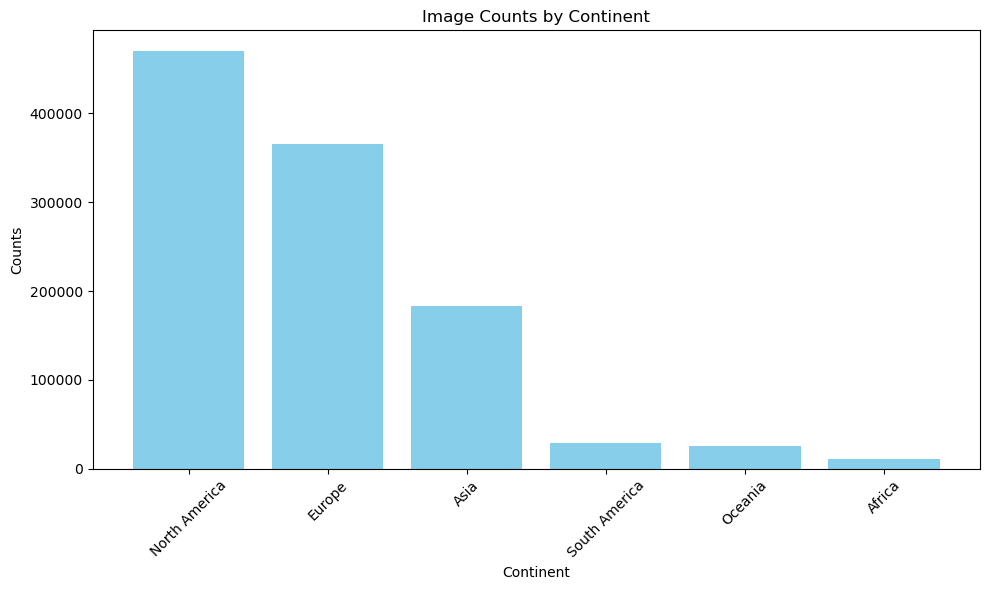

In [6]:
# Display the continent counts
print(continent_counts)

continent_counts = continent_counts.sort_values(by='counts', ascending=False)
#Plotting the data
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.bar(continent_counts['continent'], continent_counts['counts'], color='skyblue')  # Create a bar plot
plt.title('Image Counts by Continent')  # Title of the plot
plt.xlabel('Continent')  # Label for the x-axis
plt.ylabel('Counts')  # Label for the y-axis
plt.xticks(rotation=45)  # Rotate the labels on the x-axis for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [7]:
#Resolution
print("Width Summary:")
print(df['width'].describe())
print("\nHeight Summary:")
print(df['height'].describe())

Width Summary:
count    450774.000000
mean       3253.120076
std        1582.039281
min          16.000000
25%        2048.000000
50%        3264.000000
75%        4032.000000
max       34755.000000
Name: width, dtype: float64

Height Summary:
count    450774.000000
mean       2623.606976
std        1237.465426
min          16.000000
25%        1913.000000
50%        2592.000000
75%        3240.000000
max       19600.000000
Name: height, dtype: float64


In [8]:
# Calculate aspect ratios
df['aspect_ratio'] = df['width'] / df['height']

# Summary of aspect ratios
aspect_ratio_summary = df['aspect_ratio'].describe()

print("Aspect Ratio Summary:")
print(aspect_ratio_summary)

# Frequency of common aspect ratios
common_aspect_ratios = df['aspect_ratio'].value_counts().head(5)
print("\nCommon Aspect Ratios:")
print(common_aspect_ratios)

Aspect Ratio Summary:
count    450774.000000
mean          1.275108
std           0.372029
min           0.125151
25%           1.000000
50%           1.333333
75%           1.500000
max          21.413276
Name: aspect_ratio, dtype: float64

Common Aspect Ratios:
1.333333    150235
1.500000     41042
0.750000     30591
1.000000     30209
1.777778     26994
Name: aspect_ratio, dtype: int64


In [9]:
df['country'].describe()

count     19757
unique      117
top       Japan
freq       6706
Name: country, dtype: object

In [30]:
df['description'].describe()
# Determine non-empty and non-null descriptions
non_empty_descriptions = df['description'].apply(lambda x: isinstance(x, str) and x.strip() != '')

# Calculate the percentage of non-empty/non-null descriptions
percentage_with_descriptions = (non_empty_descriptions.sum() / len(df) * 100)

print(f"Percentage of data with descriptions: {percentage_with_descriptions:.2f}%")

# Calculate the length of each text entry
df['description'] = df['description'].astype(str).apply(len)

# Calculate the average length of the text in the column
average_length = df['description'].mean()

print("Average length of description:", average_length)

Percentage of data with descriptions: 44.96%
Average length of description: 151.27149017911884


In [21]:
df['tags'].describe()
# Determine non-empty and non-null descriptions
non_empty_tags = df['tags'].apply(lambda x: isinstance(x, str) and x.strip() != '')

# Calculate the percentage of non-empty/non-null descriptions
percentage_with_tags = (non_empty_tags.sum() / len(df) * 100)

print(f"Percentage of data with tags: {percentage_with_tags:.2f}%")

Percentage of data with tags: 76.04%


In [31]:
df['caption'].describe()
# Determine non-empty and non-null descriptions
non_empty_captions = df['caption'].apply(lambda x: isinstance(x, str) and x.strip() != '')

# Calculate the percentage of non-empty/non-null descriptions
percentage_with_captions = (non_empty_captions.sum() / len(df) * 100)

print(f"Percentage of data with captions: {percentage_with_captions:.2f}%")

# Calculate the length of each text entry
df['caption_length'] = df['caption'].astype(str).apply(len)

# Calculate the average length of the text in the column
average_length = df['caption_length'].mean()

print("Average length of caption:", average_length)

Percentage of data with captions: 0.49%
Average length of caption: 3.3024751503656886


In [32]:
df['title'].describe()
# Determine non-empty and non-null descriptions
non_empty_titles = df['title'].apply(lambda x: isinstance(x, str) and x.strip() != '')

# Calculate the percentage of non-empty/non-null descriptions
percentage_with_titles = (non_empty_titles.sum() / len(df) * 100)

print(f"Percentage of data with titles: {percentage_with_titles:.2f}%")

# Calculate the length of each text entry
df['title_length'] = df['title'].astype(str).apply(len)

# Calculate the average length of the text in the column
average_length = df['title_length'].mean()

print("Average length of title:", average_length)

Percentage of data with titles: 85.65%
Average length of title: 18.100900023099783


In [20]:
# Calculate the percentage of non-empty/non-null descriptions
percentage_= ((non_empty_titles.sum()+non_empty_captions.sum()) / len(df) * 100)

print(f"Percentage of data with titles: {percentage_:.2f}%")

Percentage of data with titles: 86.14%


In [13]:
#Date analysis:
def convert_dates(date_item):
    # Check the type of the date_item
    if isinstance(date_item, pd.Timestamp):
        # Already a Timestamp, return as is
        return date_item
    try:
        # Assume it's a string and check if it's all digits (Unix timestamp)
        if isinstance(date_item, str) and date_item.isdigit():
            # Convert Unix timestamp to datetime
            return pd.to_datetime(date_item, unit='s')
        elif isinstance(date_item, str):
            # Convert standard datetime strings
            return pd.to_datetime(date_item)
    except Exception as e:
        # Handle exceptions that might be raised during conversion
        print(f"Error converting {date_item}: {e}")
        return pd.NaT  # Return NaT (Not a Time) for unconvertible formats

# Apply the conversion function to each date column
df['date_upload_tr'] = df['date_upload'].apply(convert_dates)
df['date_taken_tr'] = df['date_taken'].apply(convert_dates)
df['last_update_tr'] = df['last_update'].apply(convert_dates)

# Statistical Summary
summary_upload = df['date_upload_tr'].agg(['min', 'max'])
summary_taken = df['date_taken_tr'].agg(['min', 'max'])
summary_update = df['last_update_tr'].agg(['min', 'max'])

Error converting 0001-01-01 12:12:12.0: Out of bounds nanosecond timestamp: 1-01-01 12:12:12
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string format: null
Error converting null: Unknown string fo

In [14]:
# Calculate time intervals
df['upload_to_taken'] = df.apply(
    lambda row: row['date_taken_tr'] - row['date_upload_tr'] if pd.notna(row['date_taken_tr']) and pd.notna(row['date_upload_tr']) else pd.NaT,
    axis=1)

df['last_update_to_now'] = df.apply(
    lambda row: pd.Timestamp('now') - row['last_update_tr'] if pd.notna(row['last_update_tr']) else pd.NaT, axis=1)

In [15]:
# Output summary statistics
print("Upload Dates Summary:", summary_upload)
print("Taken Dates Summary:", summary_taken)
print("Update Dates Summary:", summary_update)
print("\nCalculated Time Intervals:")
print(df['upload_to_taken'].describe())
print(df['last_update_to_now'].describe())

Upload Dates Summary: min   NaN
max   NaN
Name: date_upload_tr, dtype: float64
Taken Dates Summary: min   1825-01-01 00:00:00
max   2136-02-08 05:39:35
Name: date_taken_tr, dtype: datetime64[ns]
Update Dates Summary: min   1970-01-01 00:00:00
max   2024-05-04 07:13:00
Name: last_update_tr, dtype: datetime64[ns]

Calculated Time Intervals:
count       0
unique      0
top       NaN
freq      NaN
Name: upload_to_taken, dtype: object
count                          434583
mean     2685 days 10:25:54.566783808
std      1639 days 03:28:34.062256864
min            6 days 00:48:54.574259
25%         1327 days 18:28:56.886796
50%      2805 days 11:28:19.426031008
75%         3990 days 08:18:15.884304
max        19853 days 08:01:36.721304
Name: last_update_to_now, dtype: object


C:\Users\ogechi\AppData\Local\Temp\ipykernel_3216\1565298950.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df['upload_to_taken'].describe())


In [26]:
len(df['country'].unique())
#.describe()

118

In [25]:
a = (df['country'].apply(lambda x: isinstance(x, str) and x.strip() != ''))
a.sum()

19757

In [28]:
a = (df['longitude'].apply(lambda x: isinstance(x, float) and x != np.NaN))
a.sum()

1151526

In [34]:
19757/len(df) *100

1.7157233097646079

In [35]:
list(df)

['_id',
 'title',
 'description',
 'license',
 'date_upload',
 'date_taken',
 'owner_name',
 'original_format',
 'last_update',
 'latitude',
 'longitude',
 'tags',
 'machine_tags',
 'media',
 'url',
 'width',
 'height',
 'location_id',
 'keyword',
 'source',
 'item',
 'caption',
 'metadata',
 'country',
 'capturedevice',
 'photoid',
 'accuracy',
 'page_url',
 'licenseurl',
 'isindoor',
 'category',
 'page_source',
 'address',
 'type',
 'city',
 'addres',
 'ctry',
 'country_label',
 'continent',
 'aspect_ratio',
 'date_upload_tr',
 'date_taken_tr',
 'last_update_tr',
 'upload_to_taken',
 'last_update_to_now',
 'caption_length',
 'title_length']